In [6]:
import os
import re
import glob
import time
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import sentencepiece as spm
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio import SeqIO
import pandas as pd
import subprocess
import psutil

In [7]:
#load directories. I used ecoli to do a sanity check against Dr. Sandora's notebook, but there's a cell at the end to run them all 

genome_sequences_dir = "genome_sequences"
tokenizers_dir = "tokenizers"
subsampled_genomes_dir = "subsampled_genomes"
os.makedirs(subsampled_genomes_dir, exist_ok=True)
os.makedirs(tokenizers_dir, exist_ok=True)  

org = "e_coli_genome"
genome_filename = f"{org.replace(' ', '_')}_processed.txt"

def load_genome_sequence(filename):
    start_time = time.time()
    with open(os.path.join(genome_sequences_dir, filename), 'r') as f:
        genome = f.read().upper().replace('\n', '')
    end_time = time.time()
    print(f"loaded seq in {end_time - start_time:.2f} secs")
    return genome

genome = load_genome_sequence(genome_filename)
print(f"genome size: {len(genome)}")

#we need to chunk this size to run sentencepiece. I also added periods at the end of each line because sentencepiece was giving me errors without them
L = 4192

def process_genome_into_chunks(genome, path):
    chunks = [genome[i:i+L] + '.' for i in range(0, len(genome), L)]
    with open(path, 'w') as f:
        for chunk in chunks:
            f.write(chunk + '\n')
    print(f"processed genome saved to {path}")

processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
process_genome_into_chunks(genome, processed_genome_path)

def subsample_genome(genome, size=10**6): 
    return genome[:min(size, len(genome))]


def save_subsampled_genome(org, subsample):
    subsample_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_subsampled.txt")
    chunks = [subsample[i:i+L] + '.' for i in range(0, len(subsample), L)]
    with open(subsample_path, 'w') as f:
        for chunk in chunks:
            f.write(chunk + '\n')
    print(f"subsampled genome saved to {subsample_path}")
    return subsample_path

subsampled_sequence = subsample_genome(genome)
subsampled_genome_path = save_subsampled_genome(org, subsampled_sequence)

def print_file_head(path, num_lines=5):
    with open(path, 'r') as f:
        lines = f.readlines()
    print(f"first {num_lines} lines of {path}:")
    print("".join(lines[:num_lines]))

def check_processed_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    if len(lines) == 0:
        print(f"Error: {path} is empty.")
    else:
        print(f"{path} contains {len(lines)} lines.")

print_file_head(processed_genome_path)
check_processed_file(processed_genome_path)


loaded seq in 0.01 secs
genome size: 4641650
processed genome saved to subsampled_genomes/e_coli_genome_processed.txt
subsampled genome saved to subsampled_genomes/e_coli_genome_subsampled.txt
first 5 lines of subsampled_genomes/e_coli_genome_processed.txt:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCGATATTCTGGAAAGCAATGCCAGGCAGGGGCAGGTGGCCACCGTCCTCTCTGCCCCCGCCAAAATCACCAACCACCTGGTGGCGATGATTGAAAAAACCATTAGCGGCCAGGATGCTTTACCCAATATCAGCGATGCCGAACGTATTTTTGCCGAACTTTTGACGGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAAACTTTCGTCGATCAGGAATTTGCCCAAATAAAACATGTCCTGCATGGCATTAGTTTGTTGGGGCAGTGCCCGGATAGCATCAACGCTGCGCTGATTTGCCGTGGCGAGAAAATGTCGATCGCCATTATGGCCG

In [8]:
#generate kmers from the genome seq and calculate their frequencies
#high frequency kmers can indicate important or conserved regions in the genome, and i'm creative a vocab with them which will lead to better tokenization and compression because it makes sure that common sequences are efficiently encoded

def generate_kmers(sequence, k):
    for i in range(len(sequence) - k + 1):
        yield sequence[i:i+k]

def calculate_kmer_frequencies(sequence, k):
    
    kmer_freqs = defaultdict(int)
    for kmer in generate_kmers(sequence, k):
        kmer_freqs[kmer] += 1
    
    return kmer_freqs

def create_vocabulary(kmer_freqs, vocab_size):
    sorted_kmers = sorted(kmer_freqs.items(), key=lambda x: x[1], reverse=True)
    vocab = [kmer for kmer, _ in sorted_kmers[:vocab_size]]
    return vocab

k = 6
kmer_freqs = calculate_kmer_frequencies(genome, k)

In [9]:

def train_sentencepiece_tokenizer(input_file, model_prefix, vocab_size):
    model_file = model_prefix + ".model"
    vocab_file = model_prefix + ".vocab"
    print(f"Starting training for vocab size: {vocab_size}")
    print(f"Input file: {input_file}")
    print(f"Output model file: {model_file}")
    print(f"Output vocab file: {vocab_file}")
    
    try:
        spm.SentencePieceTrainer.train(
            input=input_file,
            model_prefix=model_prefix,
            vocab_size=vocab_size,
            model_type='bpe',
            character_coverage=0.9995,
            max_sentence_length=5000,
            hard_vocab_limit = False
            
        )
        
        if os.path.exists(model_file) and os.path.exists(vocab_file):
            print(f"model & vocab files created: {model_file}, {vocab_file}")
        else:
            print(f"Error, model or  vocab file not created for {model_prefix}")
        print("training done successfully")
    except Exception as e:
        print(f"an error occurred during training: {e}")
        raise e




  0%|          | 0/8 [00:00<?, ?it/s]

Starting training for vocab size: 1000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_1000.model
Output vocab file: tokenizers/e_coli_genome_1000.vocab
model & vocab files created: tokenizers/e_coli_genome_1000.model, tokenizers/e_coli_genome_1000.vocab
training done successfully.


 12%|█▎        | 1/8 [00:13<01:37, 13.99s/it]

vocab size: 1000, compression factor: 0.23342108948326565, number of tokens: 1077459
Starting training for vocab size: 13000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_13000.model
Output vocab file: tokenizers/e_coli_genome_13000.vocab


 38%|███▊      | 3/8 [02:09<04:10, 50.09s/it]

model & vocab files created: tokenizers/e_coli_genome_13000.model, tokenizers/e_coli_genome_13000.vocab
training done successfully.
vocab size: 13000, compression factor: 0.17877802074693266, number of tokens: 805249
Starting training for vocab size: 25000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_25000.model
Output vocab file: tokenizers/e_coli_genome_25000.vocab
model & vocab files created: tokenizers/e_coli_genome_25000.model, tokenizers/e_coli_genome_25000.vocab
training done successfully.
vocab size: 25000, compression factor: 0.16642487046632123, number of tokens: 747910


 62%|██████▎   | 5/8 [06:55<05:30, 110.25s/it]

Starting training for vocab size: 37000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_37000.model
Output vocab file: tokenizers/e_coli_genome_37000.vocab
model & vocab files created: tokenizers/e_coli_genome_37000.model, tokenizers/e_coli_genome_37000.vocab
training done successfully.
vocab size: 37000, compression factor: 0.15906498766602395, number of tokens: 713748
Starting training for vocab size: 49000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_49000.model
Output vocab file: tokenizers/e_coli_genome_49000.vocab
model & vocab files created: tokenizers/e_coli_genome_49000.model, tokenizers/e_coli_genome_49000.vocab
training done successfully.
vocab size: 49000, compression factor: 0.15389656695356177, number of tokens: 689758


 88%|████████▊ | 7/8 [16:25<03:31, 211.65s/it]

Starting training for vocab size: 61000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_61000.model
Output vocab file: tokenizers/e_coli_genome_61000.vocab
model & vocab files created: tokenizers/e_coli_genome_61000.model, tokenizers/e_coli_genome_61000.vocab
training done successfully.
vocab size: 61000, compression factor: 0.14873460945999806, number of tokens: 665798
Starting training for vocab size: 73000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_73000.model
Output vocab file: tokenizers/e_coli_genome_73000.vocab
model & vocab files created: tokenizers/e_coli_genome_73000.model, tokenizers/e_coli_genome_73000.vocab
training done successfully.
vocab size: 73000, compression factor: 0.14560942768196655, number of tokens: 651292


100%|██████████| 8/8 [28:09<00:00, 211.23s/it]

Starting training for vocab size: 85000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_85000.model
Output vocab file: tokenizers/e_coli_genome_85000.vocab
model & vocab files created: tokenizers/e_coli_genome_85000.model, tokenizers/e_coli_genome_85000.vocab
training done successfully.
vocab size: 85000, compression factor: 0.14304072905109175, number of tokens: 639369
Optimal vocab size for e_coli_genome: 37000


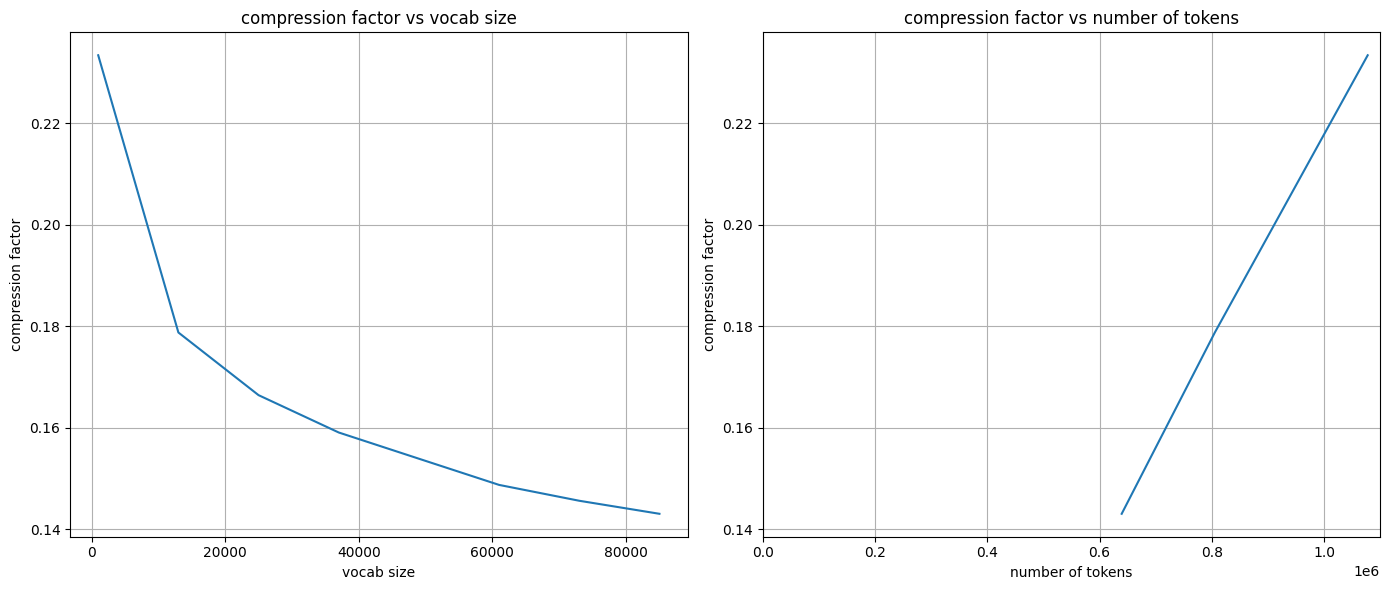

In [10]:

def calculate_compression_factor(genome, tokens, vocab):
    total_length = len(genome)
    encoded_length = len(tokens)
    vocab_length = sum(len(token) for token in vocab)
    compression_factor = (encoded_length + vocab_length) / total_length
    return compression_factor

def evaluate_vocab_sizes(genome, processed_genome_path, kmer_freqs, initial_vocab_size=1000, step_size=12000, max_vocab_size=80000):
    vocab_sizes = list(range(initial_vocab_size, max_vocab_size + step_size, step_size))
    compression_factors = []

    # go thru each vocab size and train tokenizer, calculate compression factor
    for vocab_size in tqdm(vocab_sizes):
        model_prefix = os.path.join(tokenizers_dir, f"{org}_{vocab_size}")
        try:
            train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
        except RuntimeError as e:
            if "vocab size too high" in str(e):
                max_possible_vocab_size = int(str(e).split()[-1][:-1])
                if vocab_size > max_possible_vocab_size:
                    vocab_size = max_possible_vocab_size
                    try:
                        train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
                    except RuntimeError as e:
                        continue
            else:
                raise e

        sp = spm.SentencePieceProcessor()
        sp.load(model_prefix + ".model")
        tokens = sp.encode_as_pieces(genome)
        
        #use kmer frequencies to create a vocab list and calculate the compression factor
        vocab = [token for token, _ in kmer_freqs.items()][:vocab_size]
        compression_factor = calculate_compression_factor(genome, tokens, vocab)
        compression_factors.append((vocab_size, compression_factor, len(tokens)))
        print(f'vocab size: {vocab_size}, compression factor: {compression_factor}, number of tokens: {len(tokens)}')

    return compression_factors

#find optimal vocab size based on the compression factors
def find_optimal_vocab_size(compression_factors, threshold=0.01):
    previous_factor = None
    optimal_size = None

    for vocab_size, factor, _ in sorted(compression_factors):
        if previous_factor is not None:
            change = factor - previous_factor
            if abs(change) < threshold:
                optimal_size = vocab_size
                break
        previous_factor = factor

    return optimal_size if optimal_size else max(compression_factors, key=lambda x: x[1])[0]



initial_vocab_size = 1000
step_size = 12000
max_vocab_size = 80000

compression_factors = evaluate_vocab_sizes(
    genome, processed_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
)

optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
print(f"optimal vocab size for {org}: {optimal_vocab_size}")



In [12]:

def load_and_tokenize(model_prefix, sequence):
    model_path = model_prefix + ".model"
    sp = spm.SentencePieceProcessor()
    print(f"Loading model from: {model_path}")
    sp.load(model_path) 
    tokens = sp.encode_as_pieces(sequence)
    print(f"Tokenization done. Num of tokens: {len(tokens)}")
    return tokens

# tokenize using optimal vocab size
model_prefix = os.path.join(tokenizers_dir, f"{org}_{optimal_vocab_size}")
tokens = load_and_tokenize(model_prefix, genome)


print(f"first 10 tokens: {tokens[1:11]}")

Loading model from: tokenizers/e_coli_genome_37000.model
Tokenization done. Num of tokens: 713748
first 10 tokens: ['AGCTTTTC', 'ATTCTGAC', 'TGCAACGG', 'GCAATATG', 'TCTCTGTG', 'TGGATT', 'AAAAAAAG', 'AGTGTCTG', 'ATAGC', 'AGCTTCTG']


In [13]:

for N in [1000, 41000, 81000]:
    model_path = f'{tokenizers_dir}/{org}_{N}.model'
    sp = spm.SentencePieceProcessor(model_file=model_path)
    
    print(f'vocab size: {N}')
    print('raw sequence:')
    print(genome[:100])
    print('tokenized sequence:')
    print(' '.join(sp.encode_as_pieces(genome[:100])[1:]))
    print('corresponding tokens:')
    print(' '.join([str(i) for i in sp.encode(genome[:100])[1:]]))
    print('num of tokens in genome:', len(sp.encode_as_pieces(genome)))
    print()

vocab size: 1000
raw sequence:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT
tokenized sequence:
AGC TTTTC ATTC TGAC TGC AACGG GCAA TATG TC TCTG TG TGGATT AAAA AAAG AGTG TCTG ATAGC AGC TTCTG AACTGG TTACC TGCCG TGAG TAA AT
corresponding tokens:
20 102 42 142 21 159 46 88 6 80 8 558 33 85 92 80 249 20 253 329 194 114 198 24 14
num of tokens in genome: 1077459

vocab size: 41000
raw sequence:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT
tokenized sequence:
AGCTTTTC ATTCTGAC TGCAACGG GCAATATG TCTCTGTG TGGATT AAAAAAAG AGTGTCTG ATAGC AGCTTCTG AACTGG TTACCTGCCG TGAGTAA AT
corresponding tokens:
8692 10726 36855 3772 36793 558 4267 25325 249 35869 329 32803 4954 14
num of tokens in genome: 705749

vocab size: 81000
raw sequence:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT
tokenized sequence:
AGCTTTTC ATTCTGAC TGCAACGG GCAATATG TC

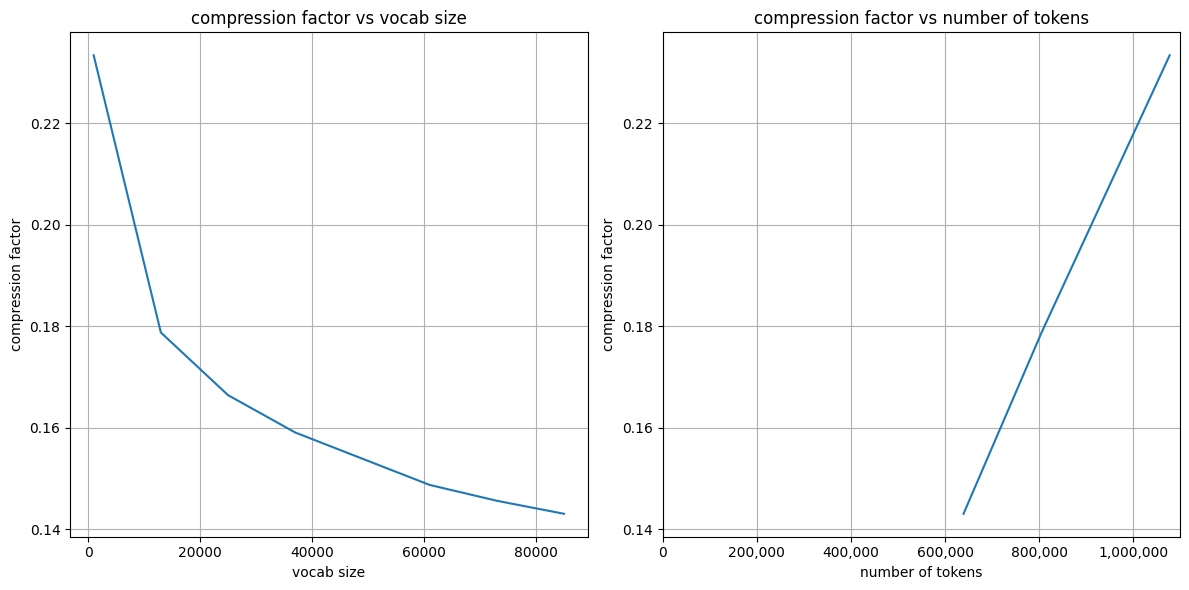

In [29]:
import matplotlib.ticker as mticker


def plot_results(compression_factors):
    vocab_sizes, compression_values, num_tokens = zip(*compression_factors)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(vocab_sizes, compression_values)
    plt.xlabel('vocab size')
    plt.ylabel('compression factor')
    plt.title('compression factor vs vocab size')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(num_tokens, compression_values)
    plt.xlabel('number of tokens')
    plt.ylabel('compression factor')
    plt.title('compression factor vs number of tokens')
    plt.grid(True)
    plt.xlim(left=0)
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.tight_layout()
    plt.show()

plot_results(compression_factors)

[('TTTG', 1077), ('TTTC', 1061), ('ACGG', 1048), ('TATT', 1046), ('AACG', 1035), ('TGAA', 1027), ('TTAA', 1024), ('TTCG', 1023), ('ACCG', 1014), ('ATGG', 1011), ('ATTG', 1009), ('TGCG', 1007), ('ACAG', 1001), ('ATAA', 1000), ('GCAA', 998), ('ATCG', 997), ('GCAG', 989), ('TCAG', 969), ('TTTT', 969), ('AGAA', 962), ('AACC', 960), ('GCTG', 959), ('TCGG', 955), ('TATC', 955), ('ATTC', 954), ('AGCG', 949), ('TGCC', 948), ('GCGG', 946), ('GCGC', 946), ('ATCC', 945)]


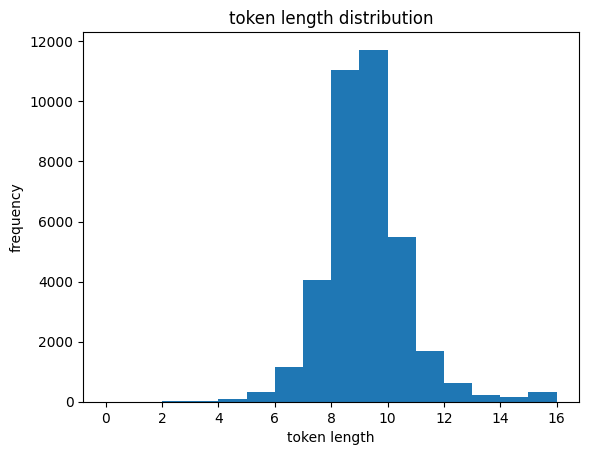

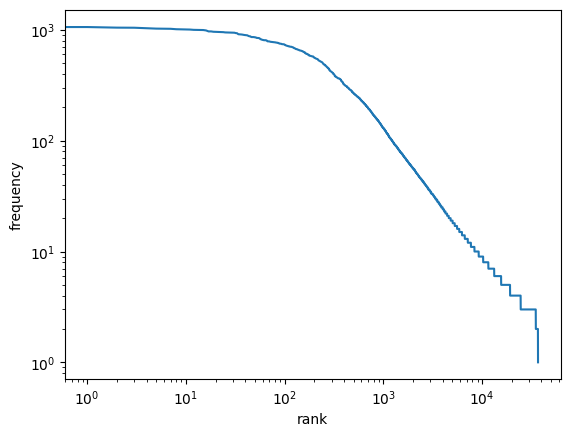

In [41]:
#note that the max token length specified is either 16 or 32 so it won't go past whichever value you  specify

org = 'e_coli_genome'
best_model_path = f'{tokenizers_dir}/{org}_{optimal_vocab_size}.model'
sp = spm.SentencePieceProcessor(model_file=best_model_path)

tokens = sp.encode_as_pieces(genome)
tokcounts = Counter(tokens).most_common()
print(tokcounts[:30])

plt.hist([len(t[0]) for t in tokcounts],
        bins=np.arange(0,max([len(t[0]) for t in tokcounts])+1))
plt.xlabel('token length')
plt.ylabel('frequency')
plt.title('token length distribution')
plt.show()

TC = [t[1] for t in tokcounts]
plt.plot(np.arange(0, len(TC), 1), TC)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('frequency')
plt.show()

In [ ]:
#run for all organisms

organisms = [
    "Nanobdella aerobiophila",
    "Candidatus Karelsulcia muelleri",
    "Malassezia restricta",
    "Caenorhabditis elegans",
    "Ostreococcus lucimarinus CCE9901",
    "Theileria orientalis strain Shintoku",
    "Rice yellow mottle virus satellite"
]


def process_organism(org):
    genome_filename = f"{org.replace(' ', '_')}_cleaned.txt"
    genome = load_genome_sequence(genome_filename)
    
    L = 4192
    processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
    process_genome_into_chunks(genome, processed_genome_path)
    
    k = 6
    kmer_freqs = calculate_kmer_frequencies(genome, k)
    
    initial_vocab_size = 1000
    step_size = 12000
    max_vocab_size = 80000
    compression_factors = evaluate_vocab_sizes(
        genome, processed_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
    )
    
    optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
    print(f"Optimal vocab size for {org}: {optimal_vocab_size}")

    plot_results(compression_factors)
    
    best_model_path = f'{tokenizers_dir}/{org}_{optimal_vocab_size}.model'
    sp = spm.SentencePieceProcessor(model_file=best_model_path)

    tokens = sp.encode_as_pieces(genome)
    tokcounts = Counter(tokens).most_common()
    print(tokcounts[:30])

    plt.hist([len(t[0]) for t in tokcounts], bins=np.arange(0, max([len(t[0]) for t in tokcounts]) + 1))
    plt.xlabel('Token length')
    plt.ylabel('Frequency')
    plt.title(f'Token Length Distribution for {org}')
    plt.show()

    TC = [t[1] for t in tokcounts]
    plt.plot(np.arange(0, len(TC), 1), TC)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title(f'Rank-Frequency Curve for {org}')
    plt.show()

for org in organisms:
    print(f"Processing {org}...")
    process_organism(org)

In [43]:
# """
# Compare different k values for kmer analysis and evaluate their impact on tokenization. I haven't had the chance to fully run it yet though
# """

# def calculate_compression_factor(genome, tokens, vocab):
#     total_length = len(genome)
#     encoded_length = len(tokens)
#     vocab_length = sum(len(token) for token in vocab)
#     compression_factor = (encoded_length + vocab_length) / total_length
#     return compression_factor

# def evaluate_vocab_sizes(genome, processed_genome_path, kmer_freqs, initial_vocab_size=1000, step_size=10000, max_vocab_size=80000):
#     vocab_sizes = list(range(initial_vocab_size, max_vocab_size + step_size, step_size))
#     compression_factors = []

#     # go thru each vocab size and train tokenizer, calculate compression factor
#     for vocab_size in tqdm(vocab_sizes):
#         model_prefix = os.path.join(tokenizers_dir, f"{org}_{vocab_size}")
#         try:
#             train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
#         except RuntimeError as e:
#             if "vocab size too high" in str(e):
#                 max_possible_vocab_size = int(str(e).split()[-1][:-1])
#                 if vocab_size > max_possible_vocab_size:
#                     vocab_size = max_possible_vocab_size
#                     try:
#                         train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
#                     except RuntimeError as e:
#                         continue
#             else:
#                 raise e

#         sp = spm.SentencePieceProcessor()
#         sp.load(model_prefix + ".model")
#         tokens = sp.encode_as_pieces(genome)
        
#         #use kmer frequencies to create a vocab list and calculate the compression factor
#         vocab = [token for token, _ in kmer_freqs.items()][:vocab_size]
#         compression_factor = calculate_compression_factor(genome, tokens, vocab)
#         compression_factors.append((vocab_size, compression_factor, len(tokens)))
#         print(f'vocab size: {vocab_size}, compression factor: {compression_factor}, number of tokens: {len(tokens)}')

#     return compression_factors

# #find optimal vocab size based on the compression factors
# def find_optimal_vocab_size(compression_factors, threshold=0.01):
#     previous_factor = None
#     optimal_size = None

#     for vocab_size, factor, _ in sorted(compression_factors):
#         if previous_factor is not None:
#             change = factor - previous_factor
#             if abs(change) < threshold:
#                 optimal_size = vocab_size
#                 break
#         previous_factor = factor

#     return optimal_size if optimal_size else max(compression_factors, key=lambda x: x[1])[0]



# initial_vocab_size = 1000
# step_size = 12000
# max_vocab_size = 80000

# compression_factors = evaluate_vocab_sizes(
#     genome, processed_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
# )

# optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
# print(f"optimal vocab size for {org}: {optimal_vocab_size}")



# # evaluate kmer frequencies and compression factors for dif k values
# def evaluate_k_values(genome, processed_genome_path, k_values, initial_vocab_size=1000, step_size=12000, max_vocab_size=80000):
#     results = {}
#     for k in k_values:
#         print(f"Evaluating k={k}")
#         kmer_freqs = calculate_kmer_frequencies(genome, k)
#         compression_factors = evaluate_vocab_sizes(
#             genome, processed_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
#         )
#         optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
#         results[k] = {
#             "optimal_vocab_size": optimal_vocab_size,
#             "compression_factors": compression_factors
#         }
#         print(f"Optimal vocab size for k={k}: {optimal_vocab_size}")
#     return results

# k_vals = [3,4,6,21,41,61,121]

# L = 4192
# processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
# process_genome_into_chunks(genome, processed_genome_path)

# results = evaluate_k_values(genome, processed_genome_path, k_vals)

# for k in k_vals:
#     print(f"plotting results for k={k}")
#     compression_factors = results[k]["compression_factors"]
#     plot_results(compression_factors)
#     optimal_vocab_size = results[k]["optimal_vocab_size"]
#     print(f"optimal vocab size for k={k}: {optimal_vocab_size}")

 12%|█▎        | 1/8 [00:14<01:39, 14.16s/it]

Starting training for vocab size: 1000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_1000.model
Output vocab file: tokenizers/e_coli_genome_1000.vocab
model & vocab files created: tokenizers/e_coli_genome_1000.model, tokenizers/e_coli_genome_1000.vocab
training done successfully.
vocab size: 1000, compression factor: 0.23342108948326565, number of tokens: 1077459
Starting training for vocab size: 13000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_13000.model
Output vocab file: tokenizers/e_coli_genome_13000.vocab


 25%|██▌       | 2/8 [00:52<02:49, 28.24s/it]

model & vocab files created: tokenizers/e_coli_genome_13000.model, tokenizers/e_coli_genome_13000.vocab
training done successfully.
vocab size: 13000, compression factor: 0.17877802074693266, number of tokens: 805249
Starting training for vocab size: 25000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_25000.model
Output vocab file: tokenizers/e_coli_genome_25000.vocab
model & vocab files created: tokenizers/e_coli_genome_25000.model, tokenizers/e_coli_genome_25000.vocab
training done successfully.
vocab size: 25000, compression factor: 0.16642487046632123, number of tokens: 747910


 50%|█████     | 4/8 [03:50<04:45, 71.43s/it]

Starting training for vocab size: 37000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_37000.model
Output vocab file: tokenizers/e_coli_genome_37000.vocab
model & vocab files created: tokenizers/e_coli_genome_37000.model, tokenizers/e_coli_genome_37000.vocab
training done successfully.
vocab size: 37000, compression factor: 0.15906498766602395, number of tokens: 713748
Starting training for vocab size: 49000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_49000.model
Output vocab file: tokenizers/e_coli_genome_49000.vocab
model & vocab files created: tokenizers/e_coli_genome_49000.model, tokenizers/e_coli_genome_49000.vocab
training done successfully.
vocab size: 49000, compression factor: 0.15389656695356177, number of tokens: 689758


 75%|███████▌  | 6/8 [10:57<05:13, 156.89s/it]

Starting training for vocab size: 61000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_61000.model
Output vocab file: tokenizers/e_coli_genome_61000.vocab
model & vocab files created: tokenizers/e_coli_genome_61000.model, tokenizers/e_coli_genome_61000.vocab
training done successfully.
vocab size: 61000, compression factor: 0.14873460945999806, number of tokens: 665798
Starting training for vocab size: 73000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_73000.model
Output vocab file: tokenizers/e_coli_genome_73000.vocab
model & vocab files created: tokenizers/e_coli_genome_73000.model, tokenizers/e_coli_genome_73000.vocab
training done successfully.
vocab size: 73000, compression factor: 0.14560942768196655, number of tokens: 651292


100%|██████████| 8/8 [22:19<00:00, 167.38s/it]

Starting training for vocab size: 85000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_85000.model
Output vocab file: tokenizers/e_coli_genome_85000.vocab
model & vocab files created: tokenizers/e_coli_genome_85000.model, tokenizers/e_coli_genome_85000.vocab
training done successfully.
vocab size: 85000, compression factor: 0.14304072905109175, number of tokens: 639369
optimal vocab size for e_coli_genome: 37000
processed genome saved to subsampled_genomes/e_coli_genome_processed.txt
Evaluating k=3



 12%|█▎        | 1/8 [00:14<01:41, 14.45s/it]

Starting training for vocab size: 1000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_1000.model
Output vocab file: tokenizers/e_coli_genome_1000.vocab
model & vocab files created: tokenizers/e_coli_genome_1000.model, tokenizers/e_coli_genome_1000.vocab
training done successfully.
vocab size: 1000, compression factor: 0.23216981030452533, number of tokens: 1077459
Starting training for vocab size: 13000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_13000.model
Output vocab file: tokenizers/e_coli_genome_13000.vocab


 25%|██▌       | 2/8 [00:52<02:49, 28.28s/it]

model & vocab files created: tokenizers/e_coli_genome_13000.model, tokenizers/e_coli_genome_13000.vocab
training done successfully.
vocab size: 13000, compression factor: 0.17352471642627082, number of tokens: 805249
Starting training for vocab size: 25000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_25000.model
Output vocab file: tokenizers/e_coli_genome_25000.vocab
model & vocab files created: tokenizers/e_coli_genome_25000.model, tokenizers/e_coli_genome_25000.vocab
training done successfully.
vocab size: 25000, compression factor: 0.16117156614565942, number of tokens: 747910


 50%|█████     | 4/8 [04:04<05:04, 76.21s/it]

Starting training for vocab size: 37000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_37000.model
Output vocab file: tokenizers/e_coli_genome_37000.vocab
model & vocab files created: tokenizers/e_coli_genome_37000.model, tokenizers/e_coli_genome_37000.vocab
training done successfully.
vocab size: 37000, compression factor: 0.1538116833453621, number of tokens: 713748
Starting training for vocab size: 49000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_49000.model
Output vocab file: tokenizers/e_coli_genome_49000.vocab
model & vocab files created: tokenizers/e_coli_genome_49000.model, tokenizers/e_coli_genome_49000.vocab
training done successfully.
vocab size: 49000, compression factor: 0.14864326263289993, number of tokens: 689758
